In [9]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg")

import sparg
import importlib
importlib.reload(sparg)
import tskit
import msprime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("always")

In [62]:
ts = tskit.load("two_pops.trees")

# 0 49 660416.0 777945.0
 
np.random.seed(4)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [63]:
ts_small, maps_small = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)

location_x = []
composition = []

subpop_and_seq_len = {sample:{ subpop:0 for subpop in range(2)} for sample in ts_small.samples()}

for tree in ts_small.trees():
    for root in tree.roots:
        if ts_small.individual(ts_small.node(root).individual).location[0] < 50:
            subpop = 0
        else:
            subpop = 1
        for sample in tree.samples(root):
            subpop_and_seq_len[sample][subpop] += tree.span

for j,sample in enumerate(subpop_and_seq_len):
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    comp_per = subpop_and_seq_len[sample][1] / sum(subpop_and_seq_len[sample].values())
    composition.append(comp_per)
    loc = ts_small.individual(ts_small.node(j).individual).location[0]
    if comp_per >= 0.4 and comp_per <= 0.6 and loc >= 40 and loc <= 60:
        sample_blocks = [[] for i in range(ts_small.num_samples)]
        ts_sample = ts_small.simplify(samples=[j], keep_input_roots=False, keep_unary=True, update_sample_flags=False)
        breakpoints = list(ts_sample.breakpoints())
        sample_blocks = []
        for tree in ts_sample.trees():
            for root in tree.roots:
                if ts_sample.individual(ts_sample.node(root).individual).location[0] < 50:
                    subpop = 0
                else:
                    subpop = 1
                for sample in tree.samples(root):
                    sample_blocks.append(subpop)
        for i,block in enumerate(sample_blocks[:-1]):
            if block != sample_blocks[i+1]:
                tree_left = list(ts_sample.at((breakpoints[i]+breakpoints[i+1])/2).nodes())
                tree_right = list(ts_sample.at((breakpoints[i+1]+breakpoints[i+2])/2).nodes())
                for node in reversed(tree_left):
                    if node not in tree_right:
                        if ts_sample.node(node).time >= 250 and ts_sample.node(node).time <= 500:
                            print(j, breakpoints[i+1], (breakpoints[i]+breakpoints[i+1])/2, (breakpoints[i+1]+breakpoints[i+2])/2, ts_sample.node(node).time)
                        break
                

63 788699.0 710431.0 804871.5 412.0
66 314087.0 271444.5 362364.5 432.0
66 794848.0 782765.0 868002.5 405.0
96 314087.0 271444.5 393793.0 432.0
96 794848.0 782765.0 806929.0 405.0


In [64]:
sample = 63
bp_interest = 788699.0

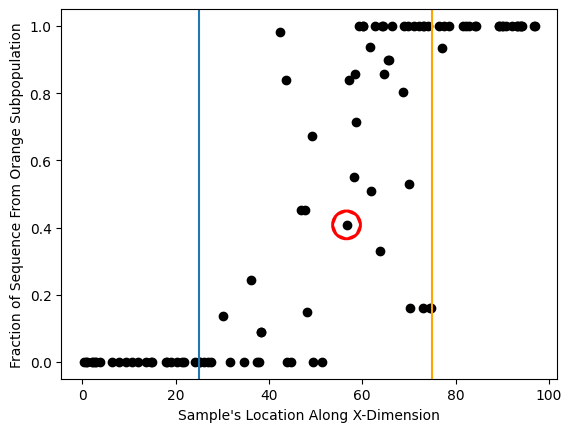

In [65]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[sample], composition[sample], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
plt.savefig("two_pops_composition.svg")
plt.show()

In [66]:
spatial_arg = sparg.SpatialARG(ts=ts_small, verbose=True)
spatial_arg.dispersal_rate_matrix = np.array([[0.25*0.25+0.5,0],[0,0.25*0.25+0.5]])

Prepared input parameters - Section Elapsed Time: 0.0 - Total Elapsed Time: 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1940/1940 [00:01<00:00, 1325.23it/s]


Calculated covariance matrix - Section Elapsed Time: 1.47 - Total Elapsed Time: 1.47
Inverted covariance matrix - Section Elapsed Time: 0.07 - Total Elapsed Time: 1.55
Created root locations vector - Section Elapsed Time: 0.84 - Total Elapsed Time: 2.38
Estimated dispersal rate - Section Elapsed Time: 0.0 - Total Elapsed Time: 2.38
Calculated Fisher's information matrices - Section Elapsed Time: 0.0 - Total Elapsed Time: 2.38
Completed building SpatialARG object - Total Elapsed Time: 2.38


In [67]:
locations_df = sparg.create_recombination_event_dataframe(
    ts=ts_sim,
    breakpoint=bp_interest,
    samples=[sample],
    include_locations=True
)

In [68]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(df=locations_df, spatial_arg=spatial_arg)

  0%|          | 0/2000 [00:00<?, ?it/s]

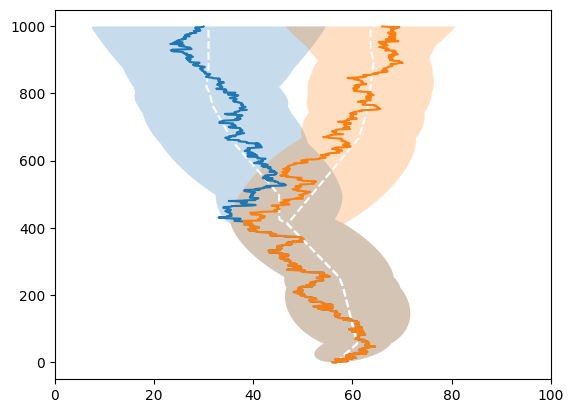

In [78]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["arg_estimated_location_0"]-1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
            right.append(row["arg_estimated_location_0"]+1.96*math.sqrt(round(row["arg_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["arg_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")

for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        plt.plot(region["true_location_0"], region["time"])

plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors_chrom.svg")
plt.show()

In [70]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=0, use_theoretical_dispersal=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

1    (786113.0, 791393.0)
Name: interval, dtype: object


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

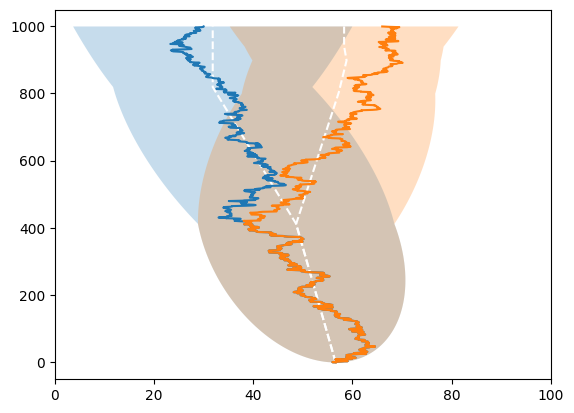

In [82]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_0_estimated_location_0"]-1.96*math.sqrt(round(row["window_0_variance_in_estimated_location_0"],3)))
            right.append(row["window_0_estimated_location_0"]+1.96*math.sqrt(round(row["window_0_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_0_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")

for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        plt.plot(region["true_location_0"], region["time"])

plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors_w0.svg")
plt.show()

In [74]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=-1, use_theoretical_dispersal=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

1       (786113.0, 788699.0)
1001    (788699.0, 791393.0)
Name: interval, dtype: object


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

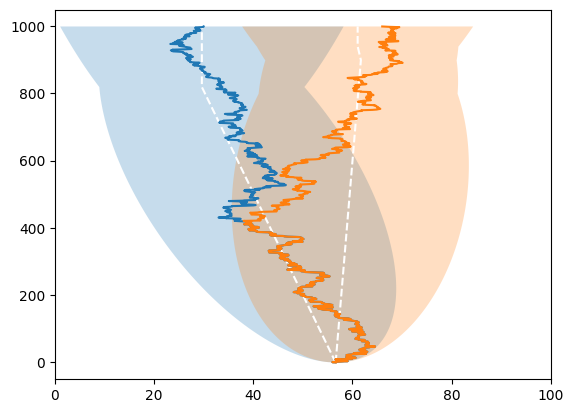

In [81]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_-1_estimated_location_0"]-1.96*math.sqrt(round(row["window_-1_variance_in_estimated_location_0"],3)))
            right.append(row["window_-1_estimated_location_0"]+1.96*math.sqrt(round(row["window_-1_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_-1_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")

for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        plt.plot(region["true_location_0"], region["time"])

plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors_w-1.svg")
plt.show()

In [77]:
locations_df = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(df=locations_df, spatial_arg=spatial_arg, window_size=100, use_theoretical_dispersal=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

1    (587371.0, 970014.0)
Name: interval, dtype: object


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

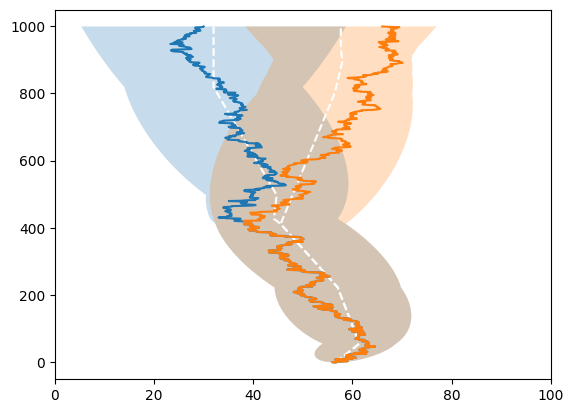

In [80]:
for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        left = []
        right = []
        for i,row in region.iterrows():
            left.append(row["window_100_estimated_location_0"]-1.96*math.sqrt(round(row["window_100_variance_in_estimated_location_0"],3)))
            right.append(row["window_100_estimated_location_0"]+1.96*math.sqrt(round(row["window_100_variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
        plt.plot(region["window_100_estimated_location_0"], region["time"], color="white", linestyle="dashed", label="Estimated Location")

for i,region in locations_df.groupby(["sample", "genome_position"]):
    if i == (sample, bp_interest-1) or i == (sample, bp_interest+1):
        plt.plot(region["true_location_0"], region["time"])

plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors_w100.svg")
plt.show()